In [22]:
import pandas as pd
import numpy as np
import orbit

from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.prebuilt import ETS

In [23]:
orbit.__version__

'1.0.16dev'

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [25]:
raw_df = load_iclaims()

raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [26]:
df = raw_df.copy()

In [27]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [28]:
test_size=52

train_df=df[:-test_size]
test_df=df[-test_size:]

In [34]:
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='stan-mcmc'
         )

In [35]:
ets.fit(train_df)


Gradient evaluation took 0.000287 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.87 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000298 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000302 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000271 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.71 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
It

Iteration: 250 / 250 [100%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Warmup)

 Elapsed Time: 0.592957 seconds (Warm-up)
               0.058035 seconds (Sampling)
               0.650992 seconds (Total)

Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 250 / 250 [100%]  (Sampling)
Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 0.651855 seconds (Warm-up)
               0.059118 seconds (Sampling)
               0.710973 seconds (Total)


 Elapsed Time: 0.654046 seconds (Warm-up)
               0.059285 seconds (Sampling)
               0.713331 seconds (Total)

Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 0.672607 seconds (Warm-up)
               0.058788 seconds (Sampling)
               0.731395 seconds (Total)



In [36]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.256516,13.386938,13.494279,12.930459,13.054487,13.172580,0.282868,0.334881,0.372885
1,2010-01-10,13.496781,13.615934,13.723689,12.949776,13.059898,13.152748,0.457965,0.551668,0.638664
2,2010-01-17,13.209483,13.388713,13.548913,12.946046,13.058421,13.194554,0.209302,0.321400,0.432713
3,2010-01-24,12.998459,13.133513,13.286931,12.938632,13.061692,13.167181,-0.015144,0.078018,0.176219
4,2010-01-31,13.034712,13.184309,13.314228,12.942450,13.071852,13.160754,0.025816,0.115216,0.214551
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.125450,12.348131,12.549590,12.223633,12.447756,12.639883,-0.114448,-0.098408,-0.079263
439,2018-06-03,12.069980,12.272860,12.468496,12.223301,12.441693,12.636694,-0.180662,-0.166661,-0.148433
440,2018-06-10,12.173838,12.373397,12.570172,12.232598,12.440506,12.641532,-0.081378,-0.065667,-0.047483
441,2018-06-17,12.146472,12.324553,12.559107,12.237100,12.420698,12.650674,-0.112112,-0.094566,-0.075579


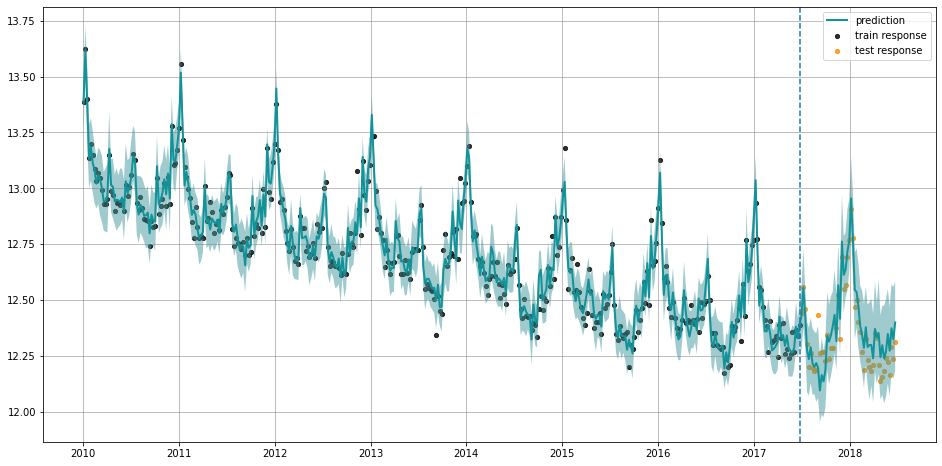

In [37]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col='week',
                        actual_col='claims',
                        test_actual_df=test_df)

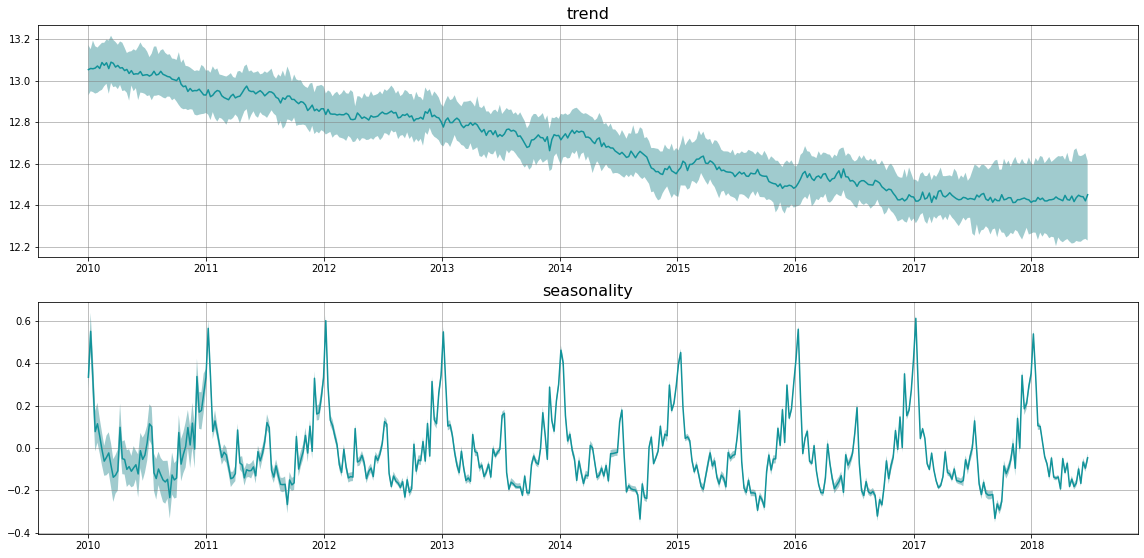

In [38]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col='week')